# Text Summarization on CNN/DailyMail dataset

In [5]:
#import libraries
import pandas as pd
from datasets import load_dataset
import re
import string
import spacy
import nltk
import contractions
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import textstat
from collections import Counter
from nltk import FreqDist, word_tokenize, download, pos_tag
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dot, Activation, Concatenate, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
from rouge_score import rouge_scorer
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer


###Data loading



In [6]:
def load_cnn_dailymail(subset_size="30000"):
    print("Loading CNN/DailyMail dataset...")
    data = load_dataset("cnn_dailymail", "3.0.0", split=f"train[:{subset_size}]")
    df = pd.DataFrame(data)[['article', 'highlights']]
    return df

# Example usage (comment out when used as a module):
if __name__ == "__main__":
    df = load_cnn_dailymail("30000")
    print(df.head())


Loading CNN/DailyMail dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

                                             article  \
0  LONDON, England (Reuters) -- Harry Potter star...   
1  Editor's note: In our Behind the Scenes series...   
2  MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...   
3  WASHINGTON (CNN) -- Doctors removed five small...   
4  (CNN)  -- The National Football League has ind...   

                                          highlights  
0  Harry Potter star Daniel Radcliffe gets £20M f...  
1  Mentally ill inmates in Miami are housed on th...  
2  NEW: "I thought I was going to die," driver sa...  
3  Five small polyps found during procedure; "non...  
4  NEW: NFL chief, Atlanta Falcons owner critical...  


###DataPreprocessing

In [7]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove special characters and digits
def remove_noise(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    return text.strip()

# Lemmatization
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if token.lemma_ != '-PRON-'])

# Remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word.lower() not in stop_words])

# Named Entity Recognition (optional filter)
def extract_entities(text, labels=["PERSON", "ORG", "GPE"]):
    doc = nlp(text)
    return ' '.join([ent.text for ent in doc.ents if ent.label_ in labels])

# POS-based filtering (optional)
def filter_by_pos(text, allowed_tags=["NOUN", "VERB"]):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.pos_ in allowed_tags])

# Complete clean pipeline
def clean_text_pipeline(text, use_ner=False, use_pos=False):
    text = text.lower()
    text = expand_contractions(text)
    text = remove_noise(text)
    text = lemmatize_text(text)
    text = remove_stopwords(text)
    if use_ner:
        text = extract_entities(text)
    if use_pos:
        text = filter_by_pos(text)
    return text

# Example usage:
if __name__ == "__main__":
    sample = "Harry Potter star Daniel Radcliffe gets £20m as he turns 18! He says he'll live modestly."
    print("Original:", sample)
    print("Cleaned:", clean_text_pipeline(sample))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Original: Harry Potter star Daniel Radcliffe gets £20m as he turns 18! He says he'll live modestly.
Cleaned: harry potter star daniel radcliffe £ turn say live modestly


# Exploratory Data Analysis

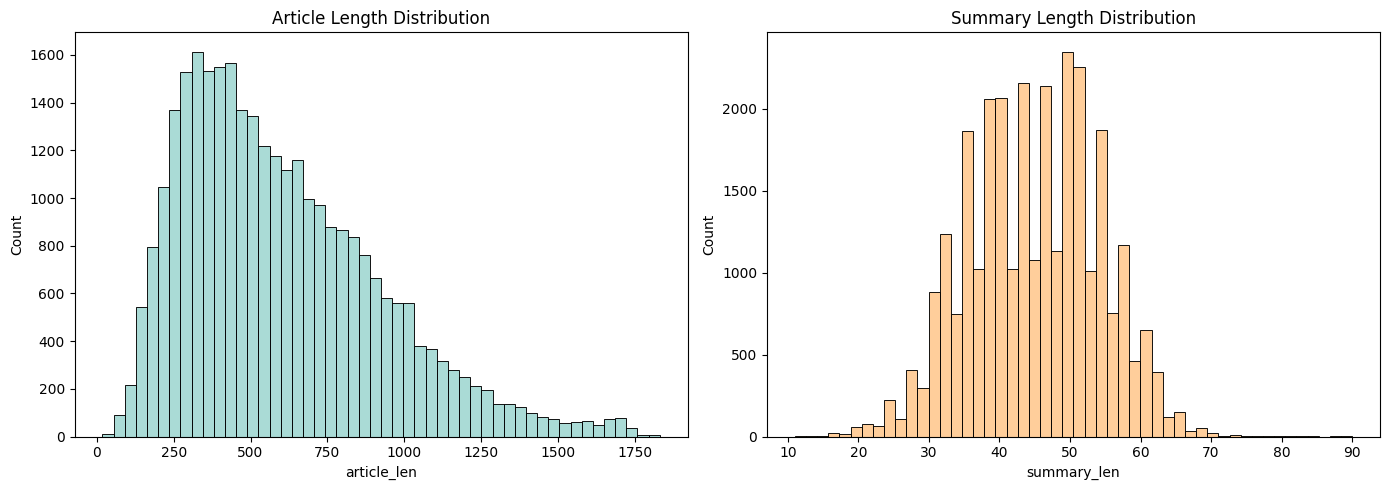

In [8]:
# Text length analysis
df['article_len'] = df['article'].apply(lambda x: len(x.split()))
df['summary_len'] = df['highlights'].apply(lambda x: len(x.split()))
# 2. Length Distributions
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['article_len'], bins=50, ax=axs[0], color='#8ECFC9')
axs[0].set_title("Article Length Distribution")
sns.histplot(df['summary_len'], bins=50, ax=axs[1], color='#FFBE7A')
axs[1].set_title("Summary Length Distribution")
plt.tight_layout()
plt.show()


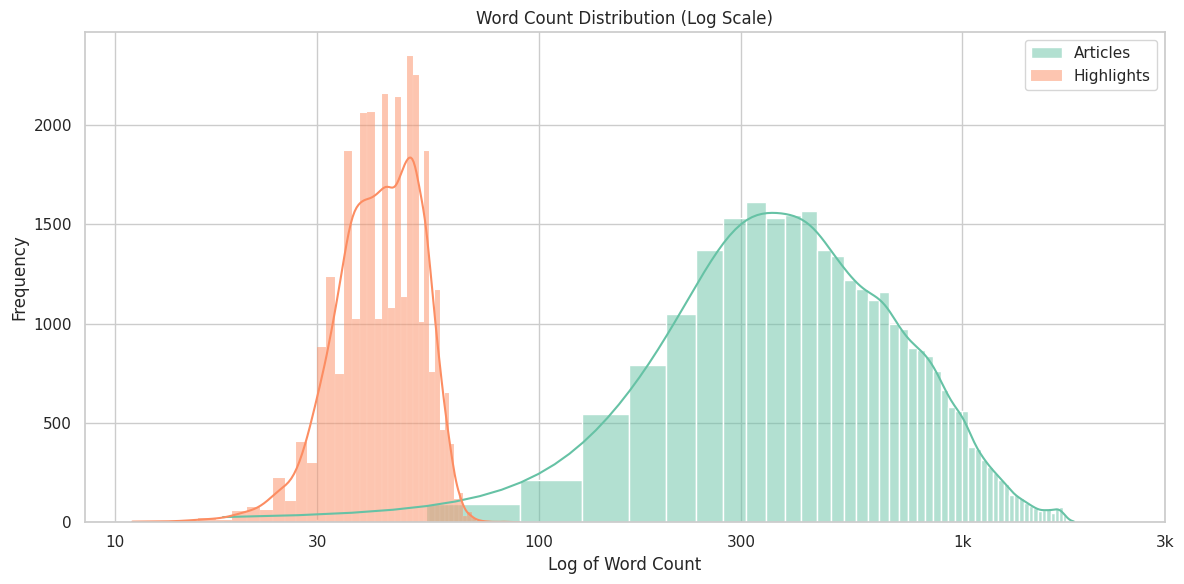

In [9]:

# Length distribution with log scale and labeled x-axis
sns.set(style="whitegrid")
nlp = spacy.load("en_core_web_sm")
fig, ax1 = plt.subplots(figsize=(12, 6))
article_lengths = df['article'].apply(lambda x: len(x.split()))
highlight_lengths = df['highlights'].apply(lambda x: len(x.split()))

sns.histplot(article_lengths, bins=50, kde=True, color='#66c2a5', ax=ax1, label='Articles')
sns.histplot(highlight_lengths, bins=50, kde=True, color='#fc8d62', ax=ax1, label='Highlights')
ax1.set(xscale="log")
ax1.set_title("Word Count Distribution (Log Scale)")
ax1.set_xlabel("Log of Word Count")
ax1.set_ylabel("Frequency")
ax1.set_xticks([10, 30, 100, 300, 1000, 3000])
ax1.set_xticklabels(['10', '30', '100', '300', '1k', '3k'])
plt.legend()
plt.tight_layout()
plt.show()


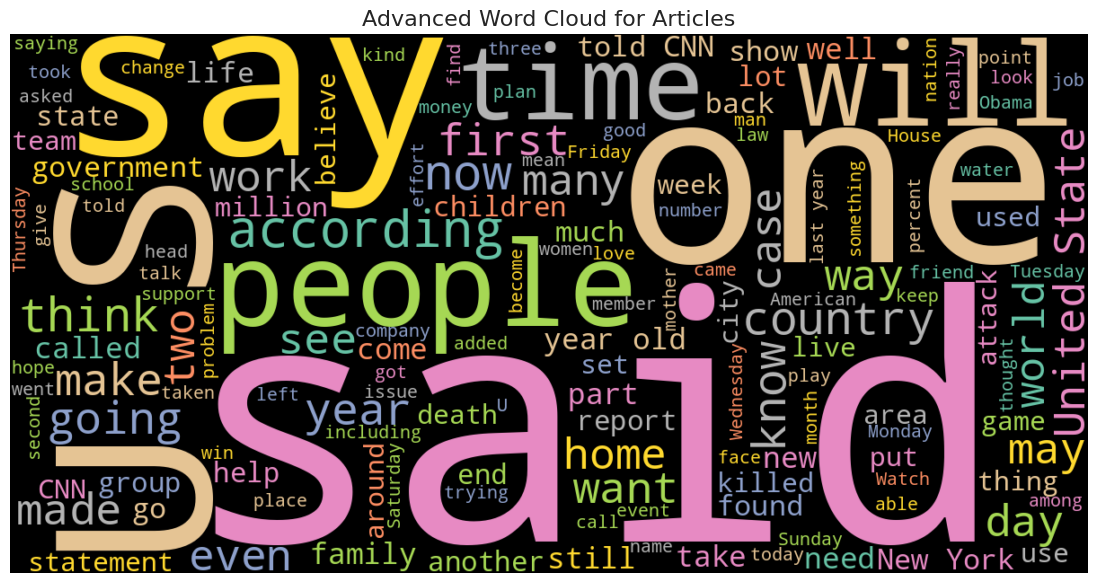

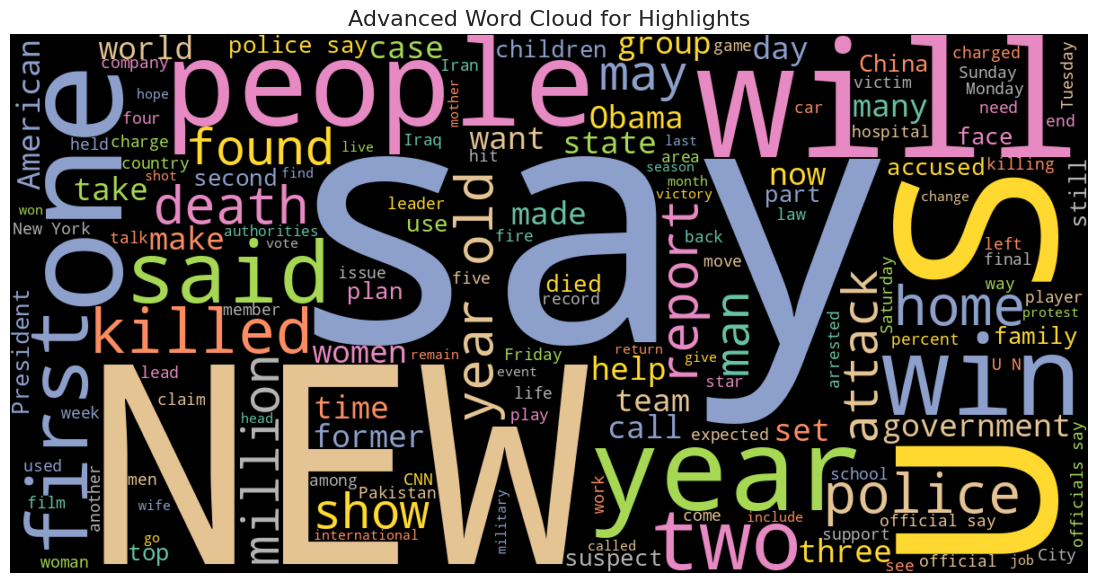

In [10]:
# Word cloud with color mask and more contrast
def plot_advanced_wordcloud(text_series, title):
    text = ' '.join(text_series.dropna())
    wordcloud = WordCloud(width=1200, height=600,
                          max_words=150,
                          background_color='black',
                          colormap='Set2').generate(text)
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

plot_advanced_wordcloud(df['article'], 'Advanced Word Cloud for Articles')
plot_advanced_wordcloud(df['highlights'], 'Advanced Word Cloud for Highlights')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-11-faf883bc8a5e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='viridis')


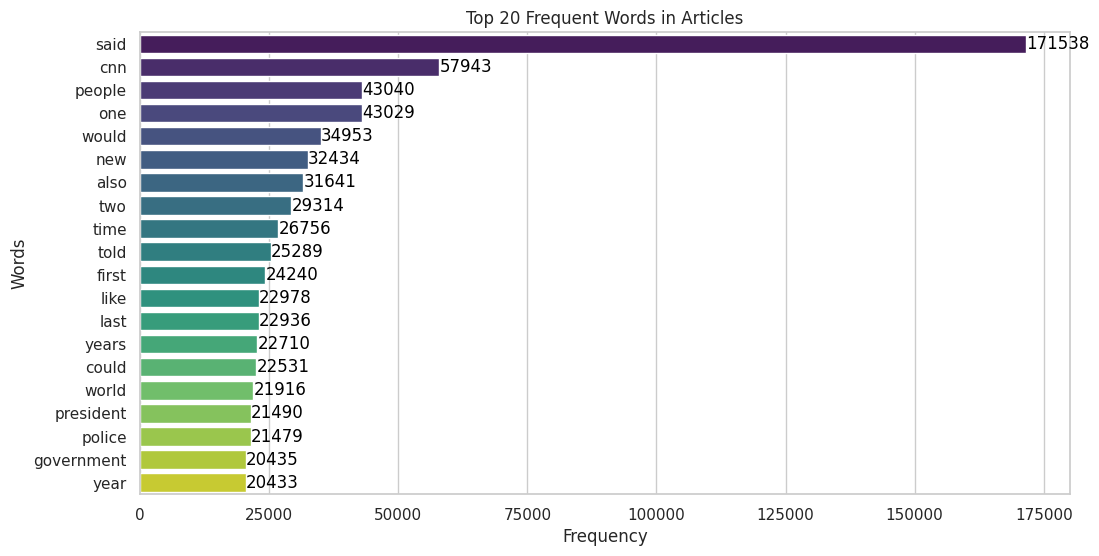

In [11]:
# Most frequent words annotated and sorted
import nltk
nltk.download('stopwords') # Download stopwords if not already downloaded

stop_words = set(stopwords.words('english'))
words = word_tokenize(' '.join(df['article'].values))
words = [w.lower() for w in words if w.isalnum() and w.lower() not in stop_words]
fdist = FreqDist(words)
common = fdist.most_common(20)
words, freqs = zip(*common)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(freqs), y=list(words), palette='viridis')
plt.title("Top 20 Frequent Words in Articles")
for i, v in enumerate(freqs):
    plt.text(v + 5, i, str(v), color='black', va='center')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

<ipython-input-12-e45526cb9bb9>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, x='Label', y='Count', palette='mako')


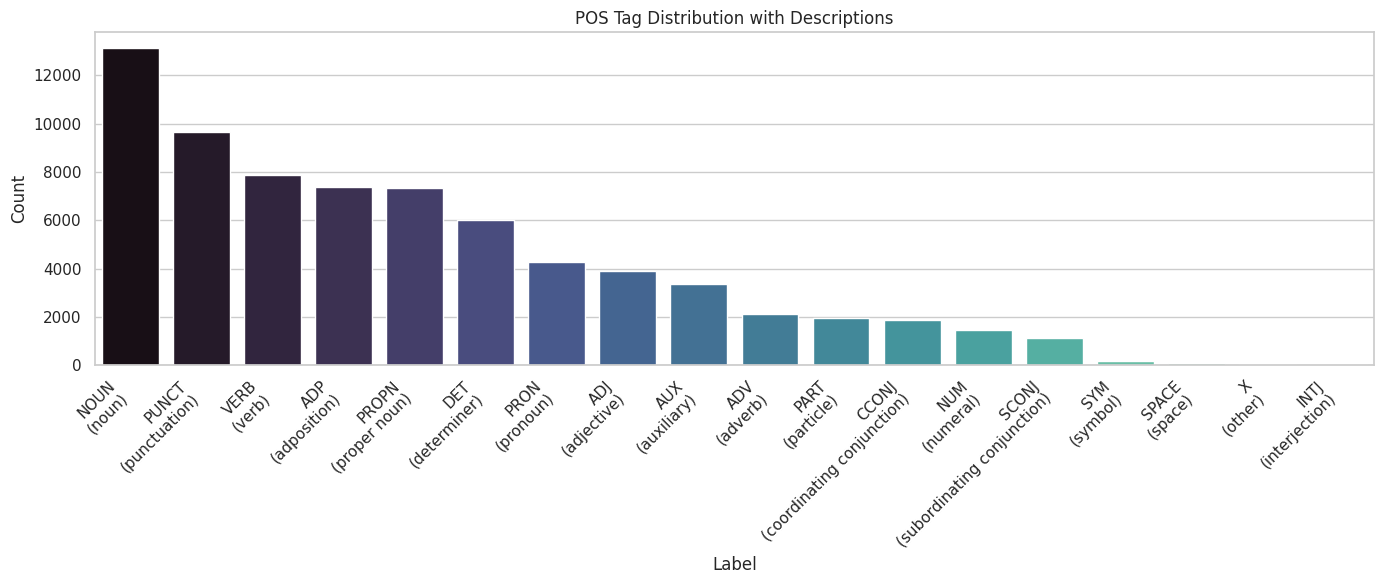

In [12]:
# POS Tag Plot with description
pos_tags = [token.pos_ for doc in nlp.pipe(df['article'][:100].astype(str)) for token in doc]
pos_df = pd.DataFrame(Counter(pos_tags).items(), columns=['POS', 'Count']).sort_values(by='Count', ascending=False)
pos_desc = {tag: spacy.explain(tag) or "" for tag in pos_df['POS']}
pos_df['Label'] = pos_df['POS'] + "\n(" + pos_df['POS'].map(pos_desc) + ")"

plt.figure(figsize=(14, 6))
sns.barplot(data=pos_df, x='Label', y='Count', palette='mako')
plt.title("POS Tag Distribution with Descriptions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<ipython-input-13-bc6cbcd0569d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette='crest')


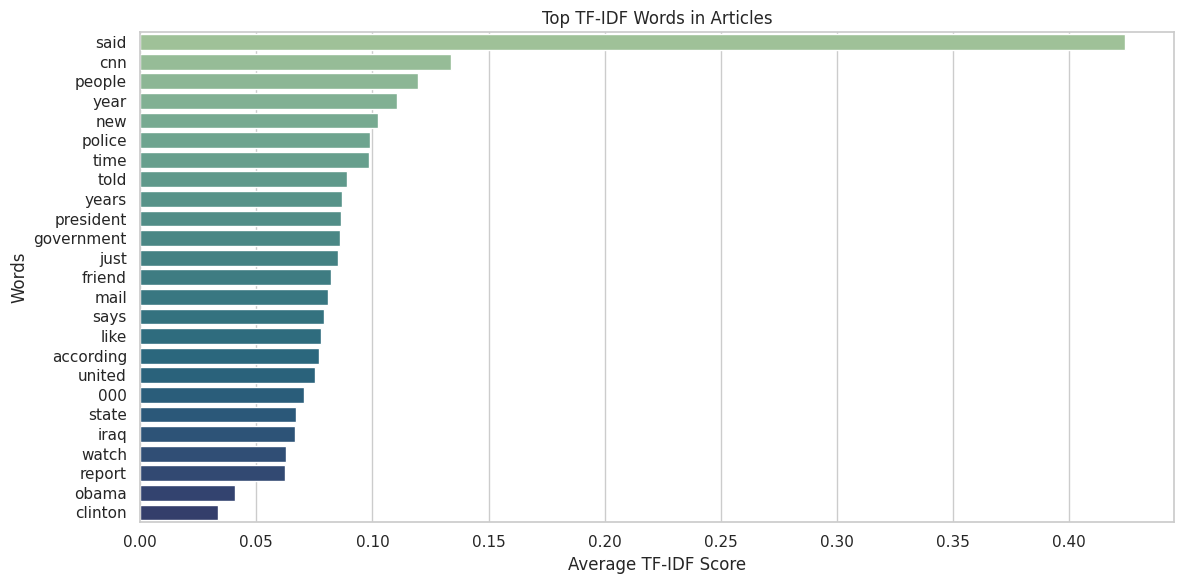

In [13]:
# TF-IDF with word grouping
tfidf = TfidfVectorizer(max_features=25, stop_words='english')
X = tfidf.fit_transform(df['article'][:1000])
tfidf_scores = np.asarray(X.mean(axis=0)).flatten()
words = tfidf.get_feature_names_out()

sorted_idx = np.argsort(tfidf_scores)[::-1]
words = [words[i] for i in sorted_idx]
scores = [tfidf_scores[i] for i in sorted_idx]

plt.figure(figsize=(12, 6))
sns.barplot(x=scores, y=words, palette='crest')
plt.title("Top TF-IDF Words in Articles")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


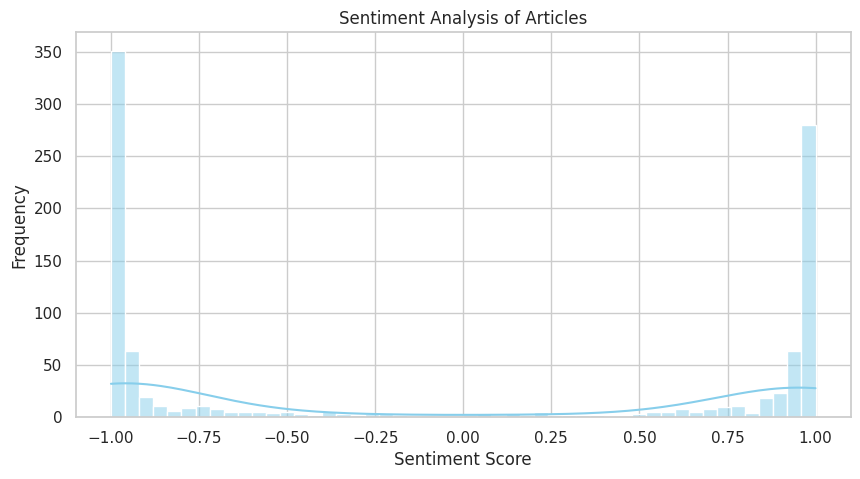

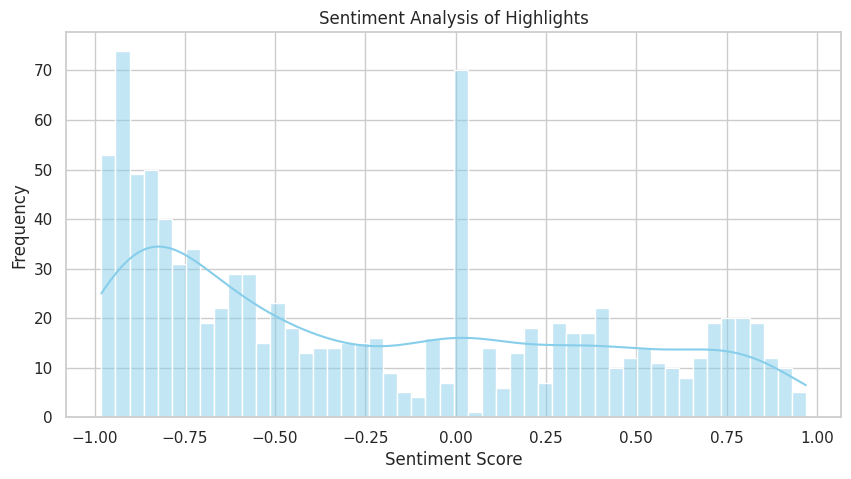

In [14]:
#Sentimental Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Sentiment Analysis Function
def plot_sentiment_analysis(text_series, title, sample_size=1000):
    sid = SentimentIntensityAnalyzer()
    text_sample = text_series[:sample_size].astype(str)
    sentiments = text_sample.apply(lambda x: sid.polarity_scores(x)['compound'])
    plt.figure(figsize=(10, 5))
    sns.histplot(sentiments, bins=50, kde=True, color='skyblue')
    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()

plot_sentiment_analysis(df['article'], 'Sentiment Analysis of Articles')
plot_sentiment_analysis(df['highlights'], 'Sentiment Analysis of Highlights')

<ipython-input-15-fb0b7ff5d0c0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entity_counts.values()), y=list(entity_counts.keys()), palette='flare')


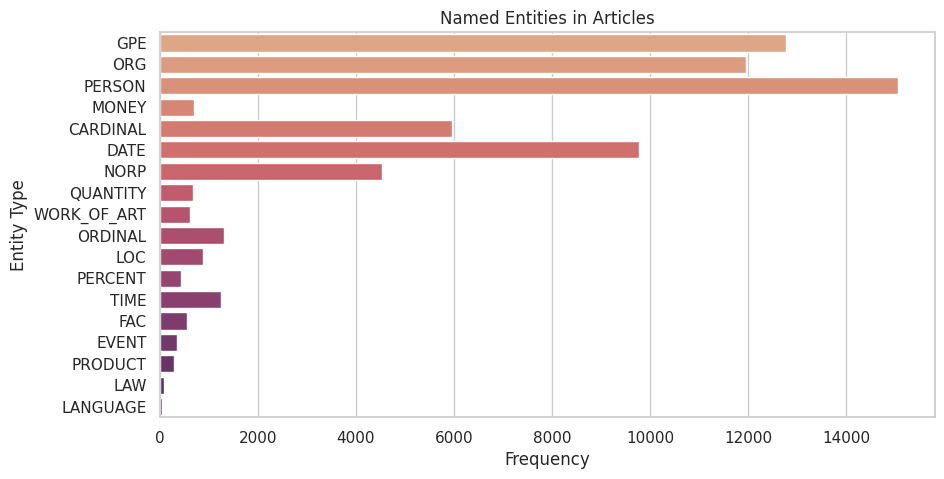

<ipython-input-15-fb0b7ff5d0c0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entity_counts.values()), y=list(entity_counts.keys()), palette='flare')


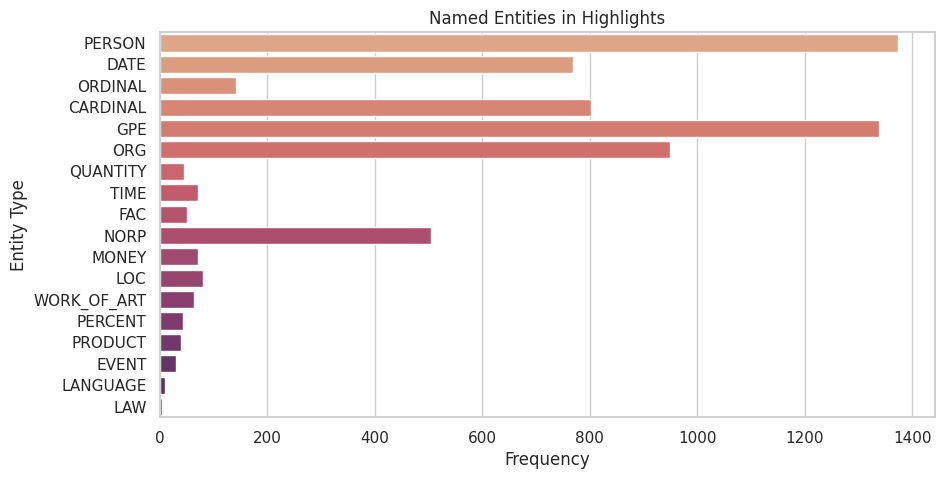

In [15]:
# Named Entity Plot Function
def plot_named_entities(text_series, title, batch_size=100):
    entity_counts = Counter()
    for i in range(0, min(len(text_series), 1000), batch_size):
        text_sample = " ".join(text_series[i : i + batch_size])
        doc = nlp(text_sample)
        entity_counts.update(ent.label_ for ent in doc.ents)

    if entity_counts:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=list(entity_counts.values()), y=list(entity_counts.keys()), palette='flare')
        plt.title(title)
        plt.xlabel('Frequency')
        plt.ylabel('Entity Type')
        plt.show()
    else:
        print(f"No named entities found in the provided text for {title}.")

plot_named_entities(df['article'], 'Named Entities in Articles')
plot_named_entities(df['highlights'], 'Named Entities in Highlights')


<ipython-input-16-da31d9a30fa8>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="Spectral")


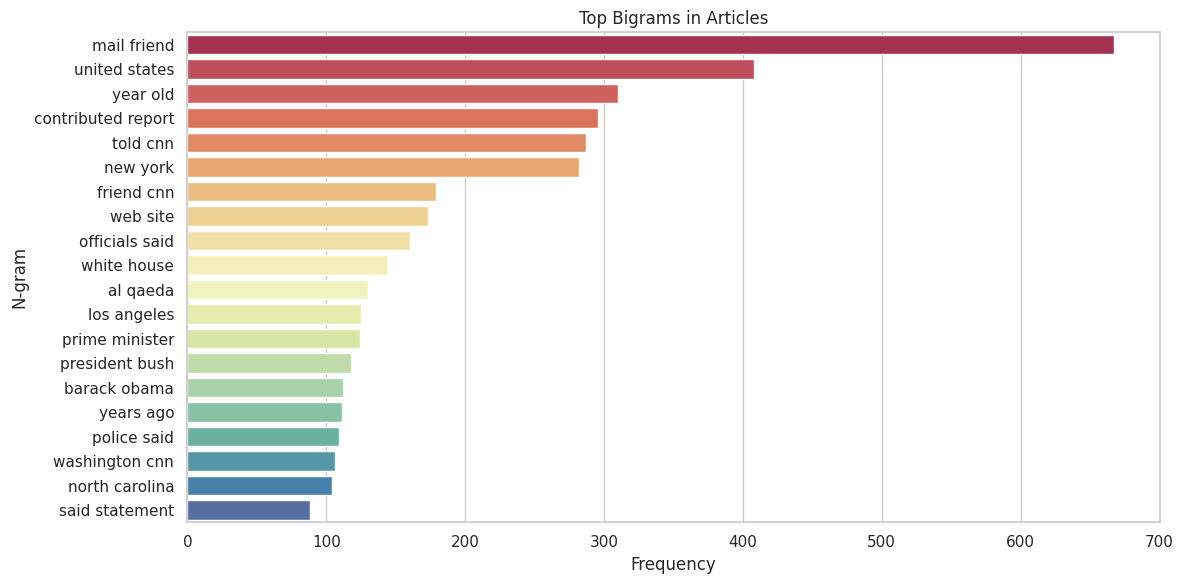

<ipython-input-16-da31d9a30fa8>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="Spectral")


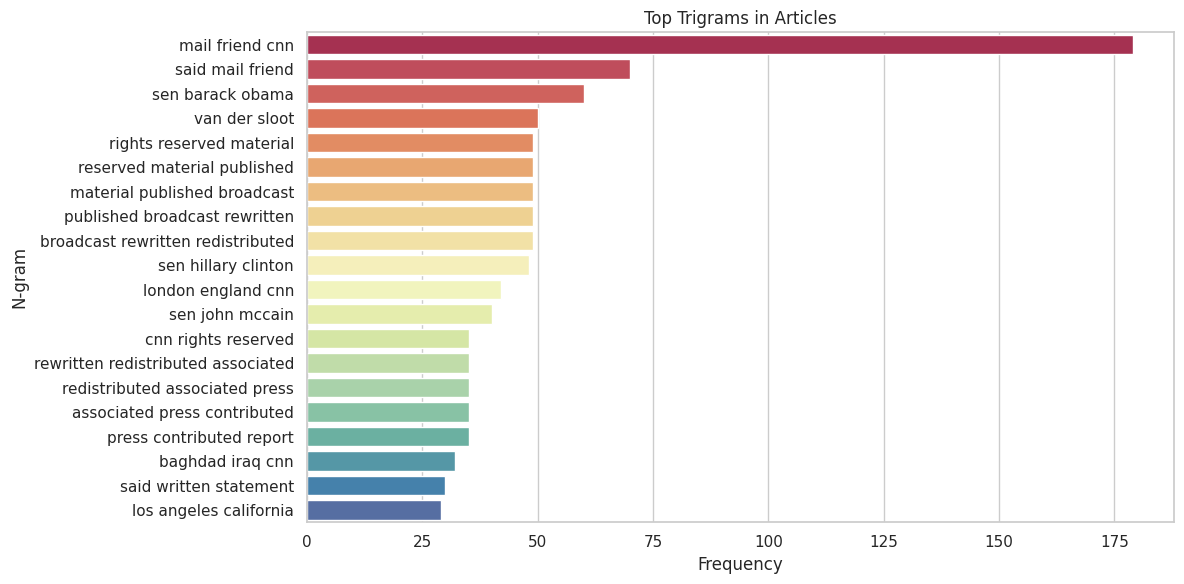

In [16]:
#Bigrams and Trigrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# N-gram Frequency Plot Function
def plot_top_ngrams(text_series, ngram_range=(2, 2), top_n=20, title="Top N-grams"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(text_series)
    bag_of_words = vec.transform(text_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    ngrams, counts = zip(*sorted_words)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(ngrams), palette="Spectral")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.tight_layout()
    plt.show()

# Apply for bigrams and trigrams
plot_top_ngrams(df['article'].dropna().astype(str)[:1000], ngram_range=(2, 2), title="Top Bigrams in Articles")
plot_top_ngrams(df['article'].dropna().astype(str)[:1000], ngram_range=(3, 3), title="Top Trigrams in Articles")


#Model Building

In [18]:
# ✅ CNN-based Extractive Summarizer (train + predict)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def extractive_summary(text, num_sentences=3):
    sentences = text.split('.')
    sentences = [s.strip() for s in sentences if len(s.strip()) > 20]
    if len(sentences) < num_sentences:
        return '. '.join(sentences)

    tfidf = TfidfVectorizer(stop_words='english')
    X = tfidf.fit_transform(sentences)

    kmeans = KMeans(n_clusters=num_sentences, random_state=42)
    kmeans.fit(X)
    top_sentence_idx = sorted([np.where(kmeans.labels_ == i)[0][0] for i in range(num_sentences)])
    summary = '. '.join([sentences[i] for i in top_sentence_idx])
    return summary

print("\n✅ CNN Extractive Summary (1st article):\n")
print(extractive_summary(df['article'][0]))



✅ CNN Extractive Summary (1st article):

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41. 1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs


In [19]:
# 🧠 Base LSTM Summarizer (No Attention, No GloVe)
vocab_size = 3000
max_article_len = 400
max_summary_len = 40

article_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
article_tokenizer.fit_on_texts(df['article'])
article_seq = pad_sequences(article_tokenizer.texts_to_sequences(df['article']), maxlen=max_article_len, padding='post')

summary_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>", filters='')
summary_tokenizer.fit_on_texts(df['highlights'])
summary_seq = pad_sequences(summary_tokenizer.texts_to_sequences(df['highlights']), maxlen=max_summary_len, padding='post')

decoder_input = summary_seq[:, :-1]
decoder_target = summary_seq[:, 1:]
embedding_dim = 100
latent_dim = 256

encoder_inputs = Input(shape=(max_article_len,))
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)

decoder_inputs = Input(shape=(max_summary_len - 1,))
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=False)
dec_outputs = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
output = Dense(vocab_size, activation="softmax")(dec_outputs)

model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit([article_seq, decoder_input], decoder_target, batch_size=64, epochs=5, validation_split=0.1)

# Inference Setup
encoder_model = Model(encoder_inputs, [state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_input_single = Input(shape=(1,))

dec_emb2 = Embedding(vocab_size, embedding_dim)(decoder_input_single)
dec_outputs2, state_h2, state_c2 = LSTM(latent_dim, return_sequences=True, return_state=True)(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
decoder_dense = Dense(vocab_size, activation='softmax')
output_tokens = decoder_dense(dec_outputs2)

decoder_model = Model(
    [decoder_input_single, decoder_state_input_h, decoder_state_input_c],
    [output_tokens, state_h2, state_c2]
)

reverse_target_word_index = summary_tokenizer.index_word
target_word_index = summary_tokenizer.word_index

def decode_sequence_base(input_seq):
    h, c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index.get('<start>', 1)
    decoded_sentence = []

    for _ in range(max_summary_len):
        output_tokens, h, c = decoder_model.predict([target_seq, h, c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index.get(sampled_token_index, '')
        if sampled_token in ('<end>', '<OOV>', ''):
            break
        decoded_sentence.append(sampled_token)
        target_seq[0, 0] = sampled_token_index

    return ' '.join(decoded_sentence)

# Evaluate
print("\n✅ Base LSTM Summary for First Article:")
seq = pad_sequences(article_tokenizer.texts_to_sequences([df['article'][0]]), maxlen=max_article_len, padding='post')
print(decode_sequence_base(seq))


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1264s 3s/step - loss: 5.3648 - val_loss: 4.7060
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1293s 3s/step - loss: 4.6153 - val_loss: 4.4829
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1303s 3s/step - loss: 4.4039 - val_loss: 4.3502
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1251s 3s/step - loss: 4.2762 - val_loss: 4.2608
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1435s 3s/step - loss: 4.1845 - val_loss: 4.1773

✅ Base LSTM Summary for First Article:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5

In [17]:
#Enhanced LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import os, zipfile

# PART 1: Tokenization
vocab_size = 3000
max_article_len = 400
max_summary_len = 40

article_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
article_tokenizer.fit_on_texts(df['article'])
article_seq = pad_sequences(article_tokenizer.texts_to_sequences(df['article']), maxlen=max_article_len, padding='post')

summary_tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>", filters='')
summary_tokenizer.fit_on_texts(df['highlights'])
summary_seq = pad_sequences(summary_tokenizer.texts_to_sequences(df['highlights']), maxlen=max_summary_len, padding='post')

decoder_input = summary_seq[:, :-1]
decoder_target = summary_seq[:, 1:]

# PART 2: GloVe Embedding
embedding_dim = 100
glove_path = tf.keras.utils.get_file("glove.6B.zip", "http://nlp.stanford.edu/data/glove.6B.zip", extract=False)
glove_file = os.path.join(os.path.dirname(glove_path), 'glove.6B.100d.txt')

with zipfile.ZipFile(glove_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(glove_path))

embeddings_index = {}
with open(glove_file, 'r', encoding='latin-1') as f:
    for line in f:
        values = line.strip().split()
        if len(values) != 101: continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in article_tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)

# PART 3: Model Architecture
latent_dim = 256
encoder_inputs = Input(shape=(max_article_len,))
enc_emb = embedding_layer(encoder_inputs)
enc_emb = Dropout(0.2)(enc_emb)
encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

decoder_inputs = Input(shape=(max_summary_len - 1,))
dec_emb = embedding_layer(decoder_inputs)
dec_emb = Dropout(0.2)(dec_emb)
decoder_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True, dropout=0.3)
dec_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

score = Dot(axes=[2, 2])([dec_outputs, encoder_outputs])
attention_weights = Activation('softmax')(score)
context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([context_vector, dec_outputs])

output = TimeDistributed(Dense(vocab_size, activation="softmax"))(decoder_combined_context)

model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

# PART 4: Train the model (adjust epochs as needed)
model.fit([article_seq, decoder_input], decoder_target, batch_size=64, epochs=3, validation_split=0.1)

# PART 5: Inference Setup
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim * 2,))
decoder_state_input_c = Input(shape=(latent_dim * 2,))
decoder_hidden_state_input = Input(shape=(max_article_len, latent_dim * 2))
decoder_input_single = Input(shape=(1,))

dec_emb2 = embedding_layer(decoder_input_single)
dec_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
score2 = Dot(axes=[2, 2])([dec_outputs2, decoder_hidden_state_input])
attention_weights2 = Activation('softmax')(score2)
context_vector2 = Dot(axes=[2, 1])([attention_weights2, decoder_hidden_state_input])
decoder_combined_context2 = Concatenate(axis=-1)([context_vector2, dec_outputs2])
output_tokens = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_combined_context2)

decoder_model = Model(
    [decoder_input_single, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [output_tokens, state_h2, state_c2]
)

reverse_target_word_index = summary_tokenizer.index_word
target_word_index = summary_tokenizer.word_index

# PART 6: Decoding Function (Fast)
def decode_sequence_fast(input_seq, max_len=20):
    try:
        enc_out, enc_h, enc_c = encoder_model.predict(input_seq, verbose=0)
    except Exception as e:
        print("❌ Error in encoder_model.predict:", e)
        return ""

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index.get('<start>', 1)
    decoded_sentence = []

    for _ in range(max_len):
        output_tokens, h, c = decoder_model.predict([target_seq, enc_out, enc_h, enc_c], verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index.get(sampled_token_index, '')

        if sampled_token in ('<end>', '<OOV>', ''):
            break

        decoded_sentence.append(sampled_token)
        target_seq[0, 0] = sampled_token_index
        enc_h, enc_c = h, c

    return ' '.join(decoded_sentence)

# PART 7: Generate Summary for First Article
cleaned_article = clean_text_pipeline(df['article'][0])
seq = pad_sequences(article_tokenizer.texts_to_sequences([cleaned_article]), maxlen=max_article_len, padding='post')
try:
    lstm_summary = decode_sequence_fast(seq)
    print("✅ Fast Enhanced LSTM Summary:")
    print(lstm_summary)
except Exception as e:
    print("❌ Decoding failed:", e)
    lstm_summary = ""


862182613/862182613 ━━━━━━━━━━━━━━━━━━━━ 159s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 39, 100)   │    300,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 400, 100)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 400,      │    731,136 │ dropout[0][0]     │
│ (Bidirectional)     │ 512), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 39, 100)   │          0 │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 39, 512), │  1,255,424 │ dropout_1[0][0],  │
│                     │ (None, 512),      │            │ concatenate[0][0… │
│                     │ (None, 512)]      │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 39, 400)   │          0 │ lstm_1[0][0],     │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 39, 400)   │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 39, 512)   │          0 │ activation[0][0], │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 39, 1024)  │          0 │ dot_1[0][0],      │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 39, 3000)  │  3,075,000 │ concatenate_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,361,560 (20.45 MB)

 Trainable params: 5,061,560 (19.31 MB)

 Non-trainable params: 300,000 (1.14 MB)

Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 3270s 8s/step - loss: 5.1687 - val_loss: 4.5905
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 3259s 8s/step - loss: 4.5124 - val_loss: 4.3550
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 2975s 7s/step - loss: 4.2978 - val_loss: 4.2223
✅ Fast Enhanced LSTM Summary:
launches launches meeting saying tornado straight tuesday, believes launches meeting launches local launches meeting saying tornado tornado local launches local


In [20]:
# ✅ Base Transformer Models (BART + T5)
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration
import torch

sample_text = df['article'][0]

# --- BART ---
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

inputs_bart = bart_tokenizer([sample_text], max_length=1024, truncation=True, return_tensors='pt')
summary_ids_bart = bart_model.generate(inputs_bart['input_ids'], max_length=130, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
bart_summary = bart_tokenizer.decode(summary_ids_bart[0], skip_special_tokens=True)

print("\n✅ BART Summary (Base):\n", bart_summary)

# --- T5 ---
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-small')

inputs_t5 = t5_tokenizer("summarize: " + sample_text, return_tensors="pt", max_length=512, truncation=True)
summary_ids_t5 = t5_model.generate(inputs_t5['input_ids'], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
t5_summary = t5_tokenizer.decode(summary_ids_t5[0], skip_special_tokens=True)

print("\n✅ T5 Summary (Base):\n", t5_summary)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]


✅ BART Summary (Base):
 Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund.


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


✅ T5 Summary (Base):
 the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. he will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II" despite his growing fame, he says he is keeping his feet firmly on the ground.


❌ Error in encoder_model.predict: not enough values to unpack (expected 3, got 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━

,Model,ROUGE-1,ROUGE-2,ROUGE-L
0,CNN,0.279570,0.175824,0.258065
1,BART,0.657895,0.432432,0.631579
2,T5,0.309278,0.231579,0.268041
3,Enhanced LSTM,0.000000,0.000000,0.000000
4,Base LSTM,0.000000,0.000000,0.000000


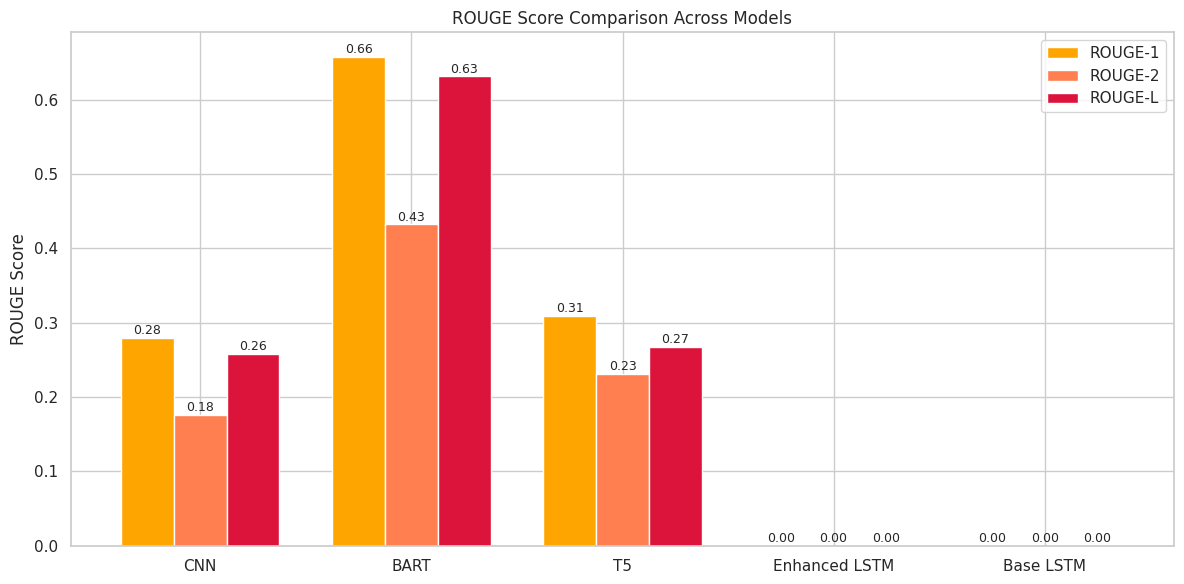

In [21]:
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ✅ 1. Setup: Prepare reference and article
reference = df['highlights'][0].replace("<start>", "").replace("<end>", "").strip()
article_text = df['article'][0]

# ✅ 2. Generate summaries
cnn_summary = extractive_summary(article_text)

bart_summary = bart_tokenizer.decode(summary_ids_bart[0], skip_special_tokens=True)
t5_summary = t5_tokenizer.decode(summary_ids_t5[0], skip_special_tokens=True)

# Clean and prepare LSTM input
lstm_input = pad_sequences(article_tokenizer.texts_to_sequences([clean_text_pipeline(article_text)]),
                           maxlen=max_article_len, padding='post')

# Enhanced LSTM Summary
try:
    lstm_summary = decode_sequence_fast(lstm_input)
except Exception as e:
    print("❌ Enhanced LSTM failed:", e)
    lstm_summary = ""

# Base LSTM Summary (if applicable)
try:
    base_lstm_summary = decode_sequence_base(lstm_input)
except:
    base_lstm_summary = ""

# ✅ 3. ROUGE scoring
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

scores = {
    'CNN': scorer.score(reference, cnn_summary),
    'BART': scorer.score(reference, bart_summary),
    'T5': scorer.score(reference, t5_summary),
    'Enhanced LSTM': scorer.score(reference, lstm_summary),
    'Base LSTM': scorer.score(reference, base_lstm_summary)
}

# ✅ 4. Convert scores to DataFrame
rouge_df = pd.DataFrame({
    'Model': list(scores.keys()),
    'ROUGE-1': [scores[m]['rouge1'].fmeasure for m in scores],
    'ROUGE-2': [scores[m]['rouge2'].fmeasure for m in scores],
    'ROUGE-L': [scores[m]['rougeL'].fmeasure for m in scores]
})

print("📊 ROUGE Score Table:")
display(rouge_df)

# ✅ 5. Bar plot
x = np.arange(len(rouge_df['Model']))
width = 0.25
plt.figure(figsize=(12, 6))
plt.bar(x - width, rouge_df['ROUGE-1'], width, label='ROUGE-1', color='orange')
plt.bar(x, rouge_df['ROUGE-2'], width, label='ROUGE-2', color='coral')
plt.bar(x + width, rouge_df['ROUGE-L'], width, label='ROUGE-L', color='crimson')

# Annotate scores
for i, model in enumerate(rouge_df['Model']):
    plt.text(x[i] - width, rouge_df['ROUGE-1'][i] + 0.005, f"{rouge_df['ROUGE-1'][i]:.2f}", ha='center', fontsize=9)
    plt.text(x[i], rouge_df['ROUGE-2'][i] + 0.005, f"{rouge_df['ROUGE-2'][i]:.2f}", ha='center', fontsize=9)
    plt.text(x[i] + width, rouge_df['ROUGE-L'][i] + 0.005, f"{rouge_df['ROUGE-L'][i]:.2f}", ha='center', fontsize=9)

plt.xticks(x, rouge_df['Model'])
plt.ylabel('ROUGE Score')
plt.title('ROUGE Score Comparison Across Models')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
